Reading cleaned games files into dataframe

In [1]:
from os import listdir
from os.path import isfile, join
import os

In [2]:
cleanedGamesFolderName = "SplitIndividualGamesCleaned"
gamesCleanedFileNames = [f for f in listdir(cleanedGamesFolderName) if isfile(join(cleanedGamesFolderName, f))]    
    #game_df = pd.read_csv(fullGameFileName,skiprows=2,header=None)
    #game_df = pd.read_fwf(fullGameFileName,skiprows=1,header=None)
#print(gamesCleanedFileNames)

In [3]:
import pandas as pd
import numpy as np
import re

In [4]:
all_games = pd.DataFrame(columns = ["PlayerADoubles", "PlayerBDoubles", "IsAWinner", "PlayerAMovedFirst", "PlayerAPoints", "PlayerBPoints", "FirstRoll"])
rowN = 0; # row index to write to dataframe
#indFLcount = 0
for fileName in gamesCleanedFileNames: # full range
#for fileName in gamesCleanedFileNames[0:500]: # testing slice
    indFL = "Y" # indicator whether the game is valid (cleaned properly)
    fullCleanedGameFileName = cleanedGamesFolderName + "/" + fileName
    PlayerADoubles = 0; # number of doubles in a game for Player A
    PlayerBDoubles = 0; # number of doubles in a game for Player B
    PlayerAPoints = 0; # number of points in a game rolled by Player A
    PlayerBPoints = 0; # number of points in a game rolled by Player B    
    column_names = ["MoveN","PlayerA_Roll","PlayerA_Move","PlayerB_Roll","PlayerB_Move"];
    game_df = pd.read_csv(fullCleanedGameFileName,delimiter=',', names=column_names, dtype=str)
    game_df = game_df.astype(str)
    for i in range(0,len(game_df)):
        RollA = game_df.PlayerA_Roll[i]
        RollB = game_df.PlayerB_Roll[i]
        if i == 0:
            if RollA == "nan":
                PlayerAMovedFirst = "N"
                sorted_roll = sorted(RollB, reverse=True)
                FirstRoll = "".join(sorted_roll)
            else:
                PlayerAMovedFirst = "Y"
                sorted_roll = sorted(RollA, reverse=True)
                FirstRoll = "".join(sorted_roll)
        if re.search(r"^[1-6][1-6]",RollA):
            if RollA[0] == RollA[1]:
                PlayerADoubles = PlayerADoubles + 1
                PlayerAPoints = PlayerAPoints + 2 * (int(RollA[0]) + int(RollA[1]))
            else:
                PlayerAPoints = PlayerAPoints + (int(RollA[0]) + int(RollA[1]))
        if re.search(r"^[1-6][1-6]",RollB):
            if RollB[0] == RollB[1]:
                PlayerBDoubles = PlayerBDoubles + 1
                PlayerBPoints = PlayerBPoints + 2 * (int(RollB[0]) + int(RollB[1]))
            else:
                PlayerBPoints = PlayerBPoints + (int(RollB[0]) + int(RollB[1]))
        if i == len(game_df)-1:
            if re.search("Wins",game_df.PlayerA_Move[i]):
                IsAWinner = "Y"
            elif re.search("Wins",game_df.PlayerB_Move[i]):
                IsAWinner = "N"
            else:
                indFL = "N"
                #indFLcount = indFLcount + 1
                #print(fileName)
                #print("ERROR: NO WINNER FOUND")
    if indFL == "Y":
        all_games.loc[rowN] = [PlayerADoubles] + [PlayerBDoubles] + [IsAWinner] + [PlayerAMovedFirst] + [PlayerAPoints] + [PlayerBPoints] + [FirstRoll]
        rowN = rowN + 1
    if len(FirstRoll) != 2:
        print("First Roll length is less than 2", fileName)
#print(indFLcount)    

In [5]:
all_games["PlayerAMoreDoubles"] = all_games["PlayerADoubles"] - all_games["PlayerBDoubles"]
all_games["PlayerAMoreDoubles"] = all_games["PlayerAMoreDoubles"].apply(lambda x: np.sign(x))
all_games["PlayerAMorePoints"] = all_games["PlayerAPoints"] - all_games["PlayerBPoints"]
all_games["PlayerAMorePoints"] = all_games["PlayerAMorePoints"].apply(lambda x: np.sign(x))

In [6]:
# calculating if winner rolled more doubles
WinnerHadMoreDoubles = list()
for i in range(0,len(all_games)):
    IsAW = all_games.IsAWinner[i]
    PAMoreD = all_games.PlayerAMoreDoubles[i] # Player A rolled more doubles
    if ((IsAW == "Y") & (PAMoreD == 1)) | ((IsAW == "N") & (PAMoreD == -1)):
        WinnerHadMoreDoubles.append("More")
    elif ((IsAW == "Y") & (PAMoreD == -1)) | ((IsAW == "N") & (PAMoreD == 1)):
        WinnerHadMoreDoubles.append("Less")
    elif PAMoreD == 0:
        WinnerHadMoreDoubles.append("Same")
    else:
        print("ERROR: Unhandled case")
all_games["WinnerHadMoreDoubles"] = WinnerHadMoreDoubles

In [7]:
# calculating if winner rolled more points
WinnerHadMorePoints = list()
for i in range(0,len(all_games)):
    IsAW = all_games.IsAWinner[i]
    PAMoreP = all_games.PlayerAMorePoints[i] # Player A rolled more points
    if ((IsAW == "Y") & (PAMoreP == 1)) | ((IsAW == "N") & (PAMoreP == -1)):
        WinnerHadMorePoints.append("More")
    elif ((IsAW == "Y") & (PAMoreP == -1)) | ((IsAW == "N") & (PAMoreP == 1)):
        WinnerHadMorePoints.append("Less")
    elif PAMoreP == 0:
        WinnerHadMorePoints.append("Same")
    else:
        print("ERROR: Unhandled case")
all_games["WinnerHadMorePoints"] = WinnerHadMorePoints

In [8]:
# calculating if winner moved first
WinnerMovedFirst = list()
for i in range(0,len(all_games)):
    IsAW = all_games.IsAWinner[i]
    PAMovedF = all_games.PlayerAMovedFirst[i] # Player A moved first flag
    if ((IsAW == "Y") & (PAMovedF == "Y")) | ((IsAW == "N") & (PAMovedF == "N")):
        WinnerMovedFirst.append("Y")
    else:
        WinnerMovedFirst.append("N")
all_games["WinnerMovedFirst"] = WinnerMovedFirst

In [9]:
#print(len(all_games))
all_games.head(10)

,PlayerADoubles,PlayerBDoubles,IsAWinner,PlayerAMovedFirst,PlayerAPoints,PlayerBPoints,FirstRoll,PlayerAMoreDoubles,PlayerAMorePoints,WinnerHadMoreDoubles,WinnerHadMorePoints,WinnerMovedFirst
0,11,3,N,N,337,264,61,1,1,Less,Less,Y
1,1,0,Y,Y,56,66,51,1,-1,More,Less,Y
2,2,0,N,N,105,80,32,1,1,Less,Less,Y
3,7,6,Y,Y,216,199,64,1,1,More,More,Y
4,1,1,Y,Y,40,37,41,0,1,Same,More,Y
5,6,4,Y,N,217,154,51,1,1,More,More,N
6,2,5,N,Y,203,226,63,-1,-1,More,More,N
7,5,2,Y,Y,160,132,32,1,1,More,More,Y
8,5,4,N,N,196,207,51,1,-1,Less,More,Y
9,6,9,Y,Y,271,243,42,-1,1,Less,More,Y


Counting number of games with winner rolling more,less, or same number of doubles

In [10]:
counts = all_games["WinnerHadMoreDoubles"].value_counts().to_dict()
print(counts)
counts_ratio = [counts["More"]/len(all_games)*100,counts["Less"]/len(all_games)*100,counts["Same"]/len(all_games)*100]
counts_ratio_dict = {"More": counts_ratio[0],"Less": counts_ratio[1],"Same": counts_ratio[2]}
print(counts_ratio_dict)

{'More': 5276, 'Less': 3604, 'Same': 2339}
{'More': 47.027364292717714, 'Less': 32.124075229521345, 'Same': 20.84856047776094}


<b>Create a pie chart demonstrating the ratio of games won versus more/less/equal number of doubles rolled by the winner.</b>

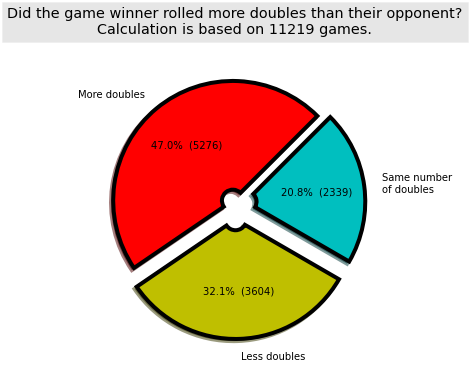

In [21]:
import matplotlib.pyplot as plt

# Data to plot
colors = ['r','y','c'] # Color of each section
explode = [0.03,0.15,0.1] # To slice the perticuler section
labels = ["More doubles","Less doubles","Same number \nof doubles"]

values = []
for x, y in counts.items():
    values.append(y)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.figure(figsize = (3,2))
wedgeprops = {"linewidth": 4, 'width':1, "edgecolor":"k"} # Width = 1
plt.pie(
        values, 
        labels = labels, 
        explode = explode, 
        colors = colors, 
        autopct = make_autopct(values), 
        pctdistance = 0.6, 
        shadow =True, 
        labeldistance = 1.15, 
        startangle = 45,
        radius = 1.1, 
        counterclock = True, 
        wedgeprops = wedgeprops,
        center=(0.5, -0.5),
        frame=True,
        )
#ax = axes([0.1, 0.1, 0.8, 0.8])
plt.axis("off")
plt.title("Did the game winner rolled more doubles than their opponent?\nCalculation is based on " + str(len(all_games)) + " games." ,bbox={'facecolor': '0.9', 'pad': 5})
#plt.show()
plt.savefig('Findings/doubles-study1.png',bbox_inches='tight')

<b>Create a pie chart demonstrating the ratio of games won versus more/less/equal number of points rolled by the winner.</b>

In [22]:
counts_points = all_games["WinnerHadMorePoints"].value_counts().to_dict()
print(counts_points)
counts_points_ratio = [counts_points["More"]/len(all_games)*100,counts_points["Less"]/len(all_games)*100,counts_points["Same"]/len(all_games)*100]
counts_points_ratio_dict = {"More": counts_points_ratio[0],"Less": counts_points_ratio[1],"Same": counts_points_ratio[2]}
print(counts_points_ratio_dict)

{'More': 5913, 'Less': 5094, 'Same': 212}
{'More': 52.705232195382834, 'Less': 45.405116320527675, 'Same': 1.889651484089491}


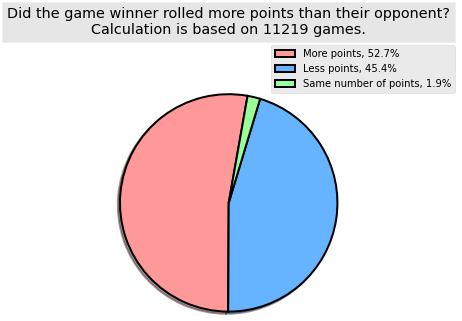

In [23]:
import matplotlib.pyplot as plt

# Data to plot
colors = ['#ff9999','#66b3ff','#99ff99'] # Color of each section
#explode = [0.1,0.15,0.1] # To slice the perticuler section
labels = ["More points","Less points","Same number of points"]

values = []
for x, y in counts_points_ratio_dict.items():
    values.append(y)

plt.figure(figsize = (2,2))
wedgeprops = {"linewidth": 2, 'width':1, "edgecolor":"k"} # Width = 1
plt.pie(
        values, 
        labels = ["","",""], 
        colors = colors, 
        pctdistance = 0.6, 
        shadow =True, 
        labeldistance = 1.15, 
        startangle = 80,
        radius = 1.0, 
        counterclock = True, 
        wedgeprops = wedgeprops,
        center=(0.5, -0.5),
        frame=True,
        )
#ax = axes([0.1, 0.1, 0.8, 0.8])
plt.axis("off")
labels = [f'{l}, {s:0.1f}%' for l, s in zip(labels, values)]
plt.legend(bbox_to_anchor=(0.84, 1), loc='upper left', labels=labels)
plt.title("Did the game winner rolled more points than their opponent?\nCalculation is based on " + str(len(all_games)) + " games." ,bbox={'facecolor': '0.9', 'pad': 5})
#plt.show()
plt.savefig('Findings/points-study1.png',bbox_inches='tight')

Counting number of games with winner moving first or second

In [24]:
counts_winner_moved_first = all_games["WinnerMovedFirst"].value_counts().to_dict()
print(counts_winner_moved_first)
counts_winner_moved_first_ratio = [counts_winner_moved_first["Y"]/len(all_games)*100,counts_winner_moved_first["N"]/len(all_games)*100]
counts_winner_moved_first_ratio_dict = {"Y": counts_winner_moved_first_ratio[0],"N": counts_winner_moved_first_ratio[1]}
print(counts_winner_moved_first_ratio_dict)

{'Y': 5817, 'N': 5402}
{'Y': 51.849540957304576, 'N': 48.150459042695424}


<b>Create the bar chart displaying dependence of ratio games won by making the first move.</b>

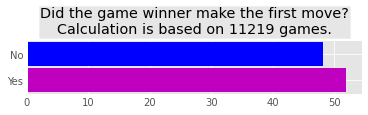

In [25]:
import matplotlib.pyplot as plt

# Data to plot
labels = ["Yes", "No"]
plt.figure(figsize=(6, 1))  # width:20, height:3    
plt.style.use('ggplot')
barlist = plt.barh(labels,counts_winner_moved_first_ratio_dict.values(),height=0.9,align='center',color = ["m","b"])
plt.title("Did the game winner make the first move?\nCalculation is based on " + str(len(all_games)) + " games." ,bbox={'facecolor': '0.9', 'pad': 1})
plt.tick_params(axis='both', labelsize=10, length = 0)
#plt.show()
plt.savefig('Findings/winner-moved-first1.png',bbox_inches='tight')

<b>Create a histogram demonstrating the ratio of games won versus specific first roll</b>

In [26]:
counts_rolls = all_games["FirstRoll"].value_counts().to_dict()
print(counts_rolls)
#counts_points_ratio = [counts_points["More"]/len(all_games)*100,counts_points["Less"]/len(all_games)*100,counts_points["Same"]/len(all_games)*100]
#counts_points_ratio_dict = {"More": counts_points_ratio[0],"Less": counts_points_ratio[1],"Same": counts_points_ratio[2]}
#print(counts_points_ratio_dict)

{'52': 822, '31': 793, '61': 764, '53': 758, '62': 757, '42': 753, '21': 749, '65': 748, '41': 745, '51': 735, '63': 730, '43': 729, '64': 726, '54': 719, '32': 691}


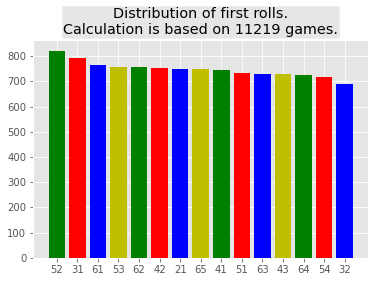

In [27]:
plt.bar(counts_rolls.keys(), counts_rolls.values(), color=['g','r','b','y'])
plt.title("Distribution of first rolls.\nCalculation is based on " + str(len(all_games)) + " games." ,bbox={'facecolor': '0.9', 'pad': 1})
plt.show()

Calculating ratios of winning the game by starting with a specific number and creating hist (or partially filled bubble plot)

In [28]:
counts_rolls_win = all_games.groupby(["FirstRoll","WinnerMovedFirst"]).size().reset_index(name="Freq")

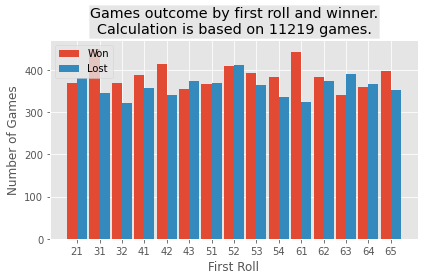

In [29]:
labels = counts_rolls_win.loc[counts_rolls_win.WinnerMovedFirst == 'N', 'FirstRoll'].to_list()
games_won = counts_rolls_win.loc[counts_rolls_win.WinnerMovedFirst == 'Y', 'Freq'].to_list()
games_lost = counts_rolls_win.loc[counts_rolls_win.WinnerMovedFirst == 'N', 'Freq'].to_list()

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, games_won, width, label='Won')
rects2 = ax.bar(x + width/2, games_lost, width, label='Lost')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("First Roll")
ax.set_ylabel("Number of Games")
ax.set_title("Games outcome by first roll and winner.\nCalculation is based on " + str(len(all_games)) + " games." ,bbox={'facecolor': '0.9', 'pad': 1})
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()
#plt.show()
plt.savefig('Findings/first-roll-success1.png',bbox_inches='tight')